In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import os

In [2]:
current = np.arange(0,7.04,0.02)
field = 1.61893 + 26.1952 * current # length of field is number of files

# directory = os.path.join("HRRYIG180", "HRRYIG180")
pwd = os.getcwd()
directory = os.path.join(pwd, "HRRPY180", "HRRPY180")

zoom_indices = None
# zoom_indices = [slice(10,60),slice(1200,1600)]

In [3]:
def read_s_params(sub_dir, log=True):
    

    files = [f for f in os.listdir(sub_dir) if f.endswith('.csv')]

    s_parameters = dict()

    freqs = pd.read_csv(os.path.join(sub_dir, files[0]), header=0, index_col=0).index.to_numpy()

    for file in files:
        data = pd.read_csv(os.path.join(sub_dir, file), header=0, index_col=0)
        for key in data.keys():
            if key not in s_parameters:
                s_parameters[key] = np.empty((len(files), len(data)))
            if log:
                out_data = 20* np.log10(np.abs(data[key].to_numpy()))
            else:
                out_data = data[key].to_numpy()
            s_parameters[key][files.index(file), :] = out_data

    s_parameters['freqs'] = freqs  

    return s_parameters

def s_param_plot(s_parameters=[], sub_dir=directory, norm=True, log=False, grad=True,zoom_indices=zoom_indices, smooth='gaussian', cmap="inferno_r", sigma=5):

    if s_parameters != []:
        s_parameters = read_s_params(sub_dir, log=log)
    
    # fig, axs = plt.subplots(2,2, figsize=(10, 10),sharey=True)
    # keys = ['S11', 'S21', 'S12', 'S22']
    fig, ax = plt.subplots(1, 1);axs = np.array([ax])
    keys = ['S21']

    for i, ax in enumerate(axs.flat):
        # 1. Prepare the full dataset from your source
        key = keys[i]
        plot_data = np.abs(s_parameters[f'{key}_Real'] + 1j*s_parameters[f'{key}_Imaginary'])
        freqs = s_parameters['freqs']

        if zoom_indices:
            # If zoom indices are provided, slice the data accordingly
            plot_data = plot_data[zoom_indices[0], zoom_indices[1]]
            field_zoom = field[zoom_indices[0]]
            # print(zoom_indices[1])
            freqs = s_parameters['freqs'][zoom_indices[1]]
        
        # --- (Optional) Data Processing on the FULL array ---
        if grad:
            # Taking the gradient with respect to the field (axis=1)
            plot_data = np.gradient(plot_data, axis=1) 
        if smooth == 'gaussian':
            plot_data = gaussian_filter1d(plot_data, sigma=sigma, axis=1)
        if norm:
            # Subtract the first column (e.g., zero-field data) from all columns.
            # The [:, np.newaxis] ensures correct broadcasting.
            plot_data = plot_data - plot_data[:, 0][:, np.newaxis]

        # 2. Determine color limits from the ENTIRE processed dataset
        if norm:
            # For normalized data, a symmetric colormap around zero is usually best.
            v_max = np.max(np.abs(plot_data))
            v_min = -v_max
        else:
            v_min = np.min(plot_data)
            v_max = np.max(plot_data)
            
        # 3. Plot the data, passing the full dataset and the global color limits
        # Matplotlib will handle displaying only the portion within the axis limits.
        # Use shading='auto' or 'gouraud' to avoid potential errors and control interpolation.
        im = ax.pcolormesh(
            field_zoom if zoom_indices else field, 
            freqs * 1e-9, 
            plot_data.T, 
            cmap=cmap, 
            vmin=v_min, 
            vmax=v_max,
            shading='gouraud'
        )

        # 4. Set the desired VIEWING window (axis limits)
        # if zoom_indices==None:
        #     ax.set_ylim(2.5,7.5)
        # ax.set_xlim(0, 100)
        
        # --- Axis labels and titles ---
        ax.set_ylabel("Freq (GHz)")
        ax.set_xlabel("Field (mT)")

    fig.suptitle(os.path.basename(sub_dir) + norm*" Normed" + grad*" Grad", fontsize=16)
    plt.tight_layout()
    plt.colorbar(im, label=f"$S_{{{key[1:]}}}$" + " (dB)"*log)

    zoom = "_zoom" if zoom_indices else ""
    smooth = "_gaussian" + smooth if smooth else ""
    filename = sub_dir + "_normalised"*norm + "_gradient" * grad + "_dB_" * log + smooth+"_smooth"+zoom+".png"
    plt.savefig(filename,transparent=True)
    plt.show()

def s_param_plot_debug(s_parameters: dict, sub_dir=directory, norm=True, log=True, grad=True, zoom_indices=zoom_indices, smooth='gaussian', cmap="inferno_r", sigma=5):
    
    # fig, axs = plt.subplots(2,2, figsize=(10, 10),sharey=True)
    # keys = ['S11', 'S21', 'S12', 'S22']
    fig, ax = plt.subplots(1, 1);axs = np.array([ax])
    keys = ['S21']

    for i, ax in enumerate(axs.flat):
        # 1. Prepare the full dataset from your source
        key = keys[i]
        plot_data = np.abs(s_parameters[f'{key}_Real'] + 1j*s_parameters[f'{key}_Imaginary'])
        freqs = s_parameters['freqs']

        if zoom_indices:
            # If zoom indices are provided, slice the data accordingly
            plot_data = plot_data[zoom_indices[0], zoom_indices[1]]
            field_zoom = field[zoom_indices[0]]
            # print(zoom_indices[1])
            freqs = s_parameters['freqs'][zoom_indices[1]]
        
        # --- (Optional) Data Processing on the FULL array ---
        if grad:
            # Taking the gradient with respect to the field (axis=1)
            plot_data = np.gradient(plot_data, axis=1) 
        if smooth == 'gaussian':
            plot_data = gaussian_filter1d(plot_data, sigma=sigma, axis=1)
        if norm:
            # Subtract the first column (e.g., zero-field data) from all columns.
            # The [:, np.newaxis] ensures correct broadcasting.
            plot_data = plot_data - plot_data[:, 0][:, np.newaxis]

        # 2. Determine color limits from the ENTIRE processed dataset
        if norm:
            # For normalized data, a symmetric colormap around zero is usually best.
            v_max = np.max(np.abs(plot_data))
            v_min = -v_max
        else:
            v_min = np.min(plot_data)
            v_max = np.max(plot_data)
            
        # 3. Plot the data, passing the full dataset and the global color limits
        # Matplotlib will handle displaying only the portion within the axis limits.
        # Use shading='auto' or 'gouraud' to avoid potential errors and control interpolation.
        im = ax.pcolormesh(
            field_zoom if zoom_indices else field, 
            freqs * 1e-9, 
            plot_data.T, 
            cmap=cmap, 
            vmin=v_min, 
            vmax=v_max,
            shading='gouraud'
        )

        # 4. Set the desired VIEWING window (axis limits)
        # ax.set_ylim(4.95, 5.1)
        # ax.set_xlim(0, 100)
        
        # --- Axis labels and titles ---
        ax.set_ylabel("Freq (GHz)")
        ax.set_xlabel("Field (mT)")
        ax.set_title(f"{key} Magnitude")

    fig.suptitle(os.path.basename(sub_dir) + norm*" Normed" + grad*" Grad", fontsize=16)
    plt.tight_layout()
    plt.colorbar(im, label=f"$S_{{{key[1:]}}}$" + " (dB)"*log)
    plt.show()

In [4]:
maps = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu',
                      'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic',
                      'berlin', 'managua', 'vanimo']

# directory = os.path.join(pwd,"HRRYIG180", "HRRYIG180")
# for map in maps:
#     print(map)
#     s_param_plot(cmap=map, sigma=5)#, norm=False) # default values

zoom_indices1 = None
zoom_indices1 = [slice(20,80),slice(1000,1700)]

# sp = read_s_params(sub_dir=directory)

# s_param_plot_debug(sp, sub_dir=directory,cmap="BuPu",sigma=5,grad=0,norm=0,smooth=None,log=0, zoom_indices=zoom_indices1) # default values
# s_param_plot(sub_dir=directory,cmap="inferno_r",sigma=5,grad=0,norm=0,smooth=None,log=0, zoom_indices=zoom_indices1) # default values

Processing directory: d:\Working files\cavityCoupling\experimental data\HRRPY180\HRRPY180


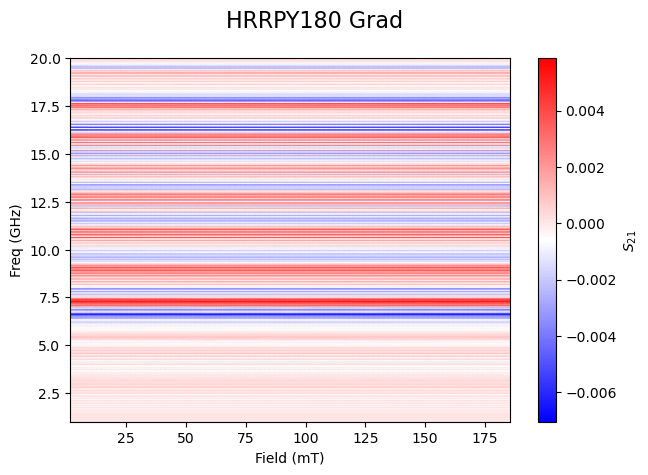

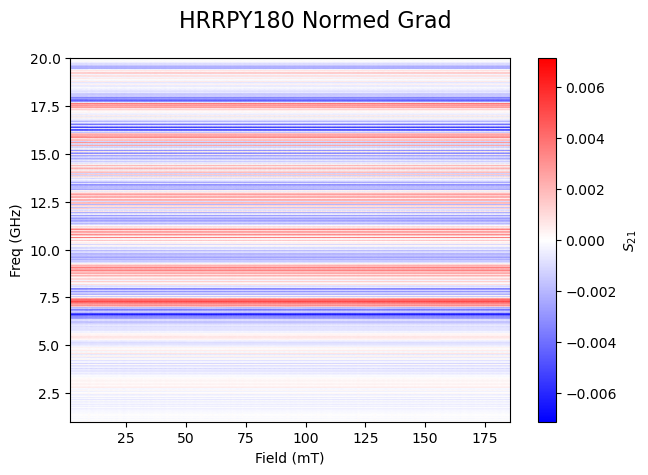

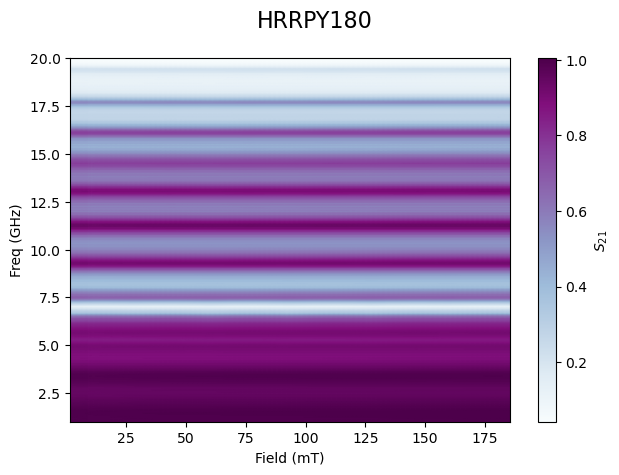

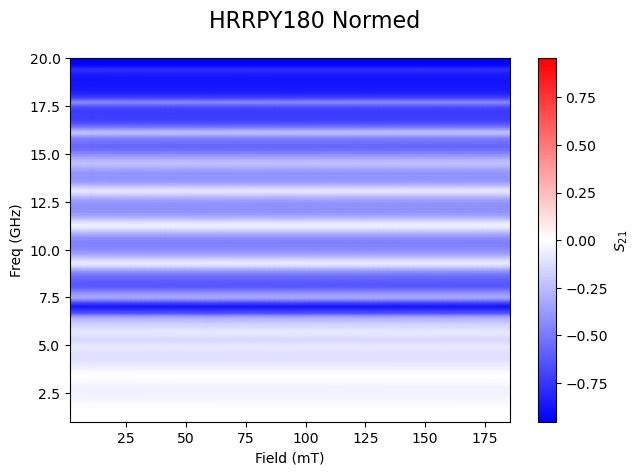

Processing directory: d:\Working files\cavityCoupling\experimental data\HRRPY180\HRRYIG_BJ_PY


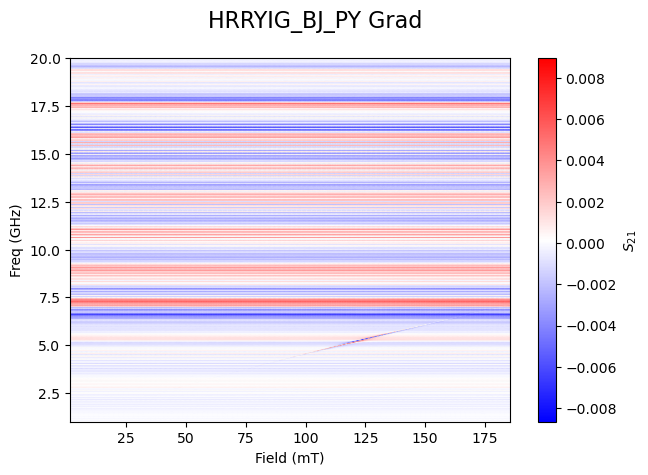

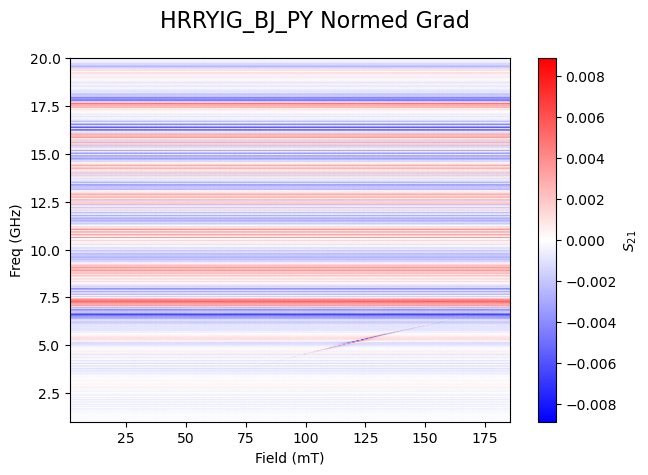

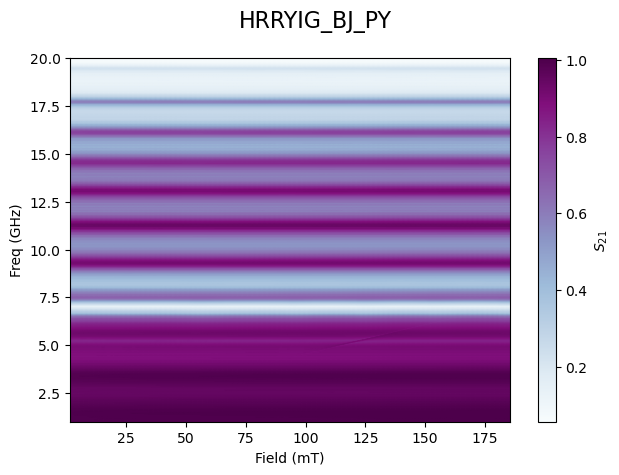

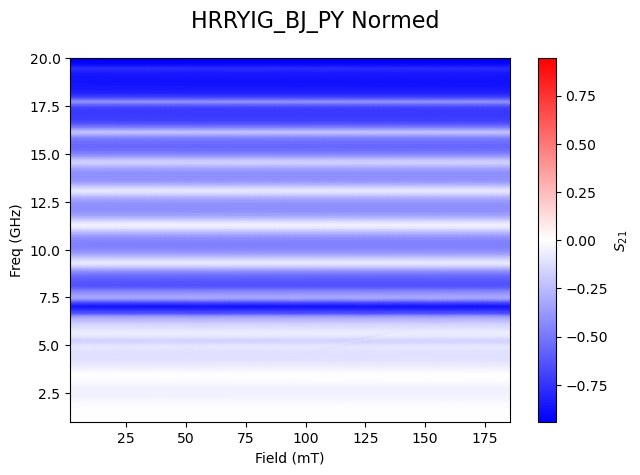

Processing directory: d:\Working files\cavityCoupling\experimental data\HRRYIG\HRRYIG180


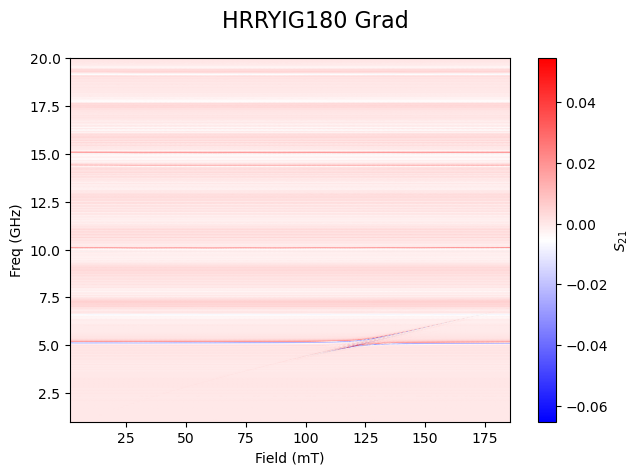

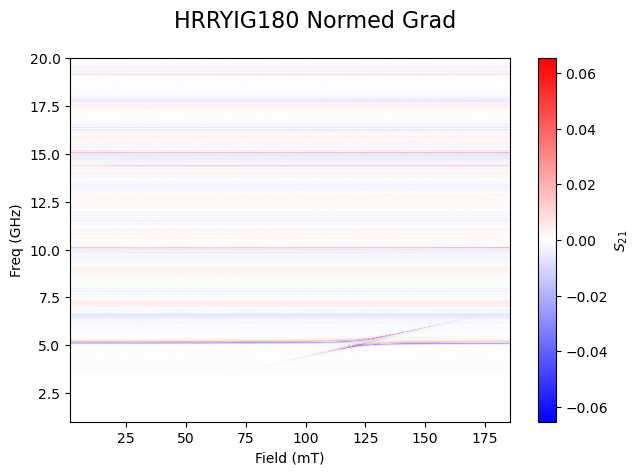

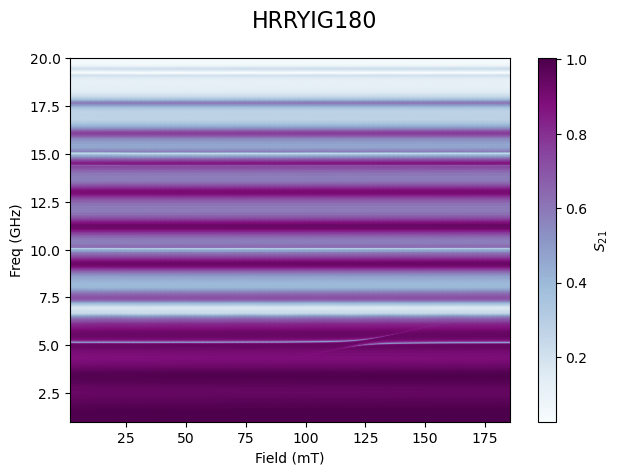

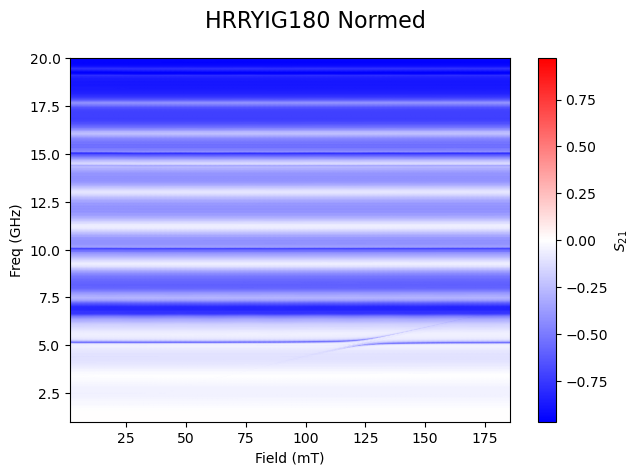

Processing directory: d:\Working files\cavityCoupling\experimental data\HRRYIG_PY\HRRYIG_PY


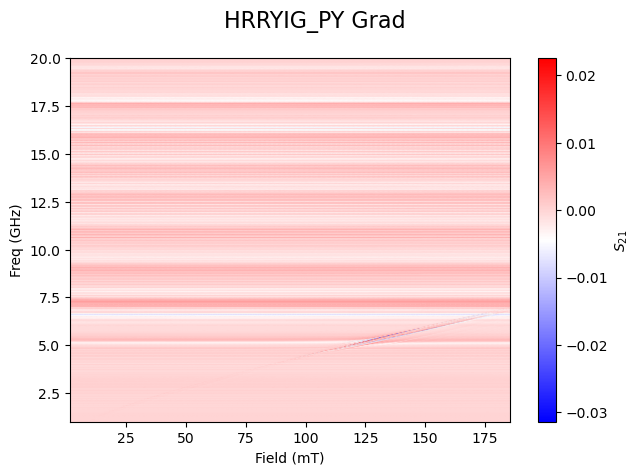

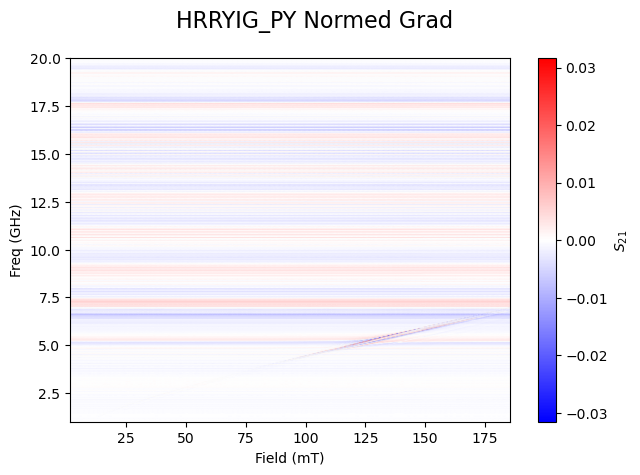

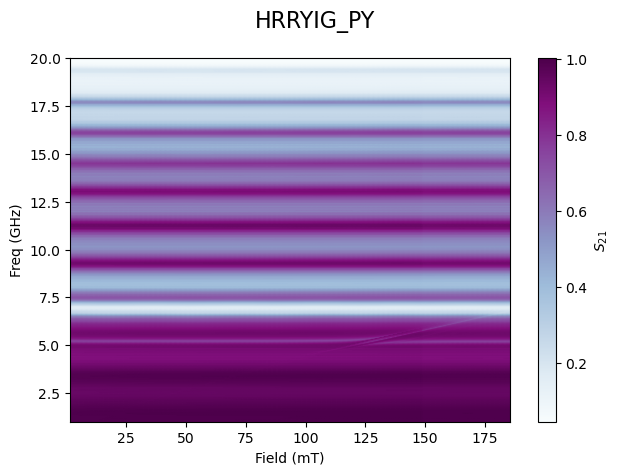

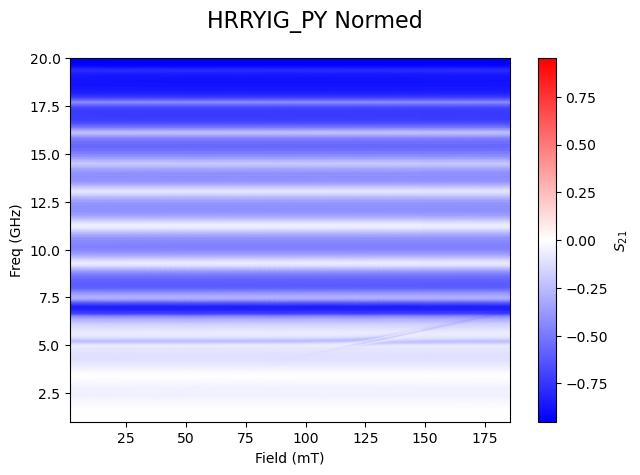

Processing directory: d:\Working files\cavityCoupling\experimental data\HRRYIG_PY\HRRYIG_SPS_PY


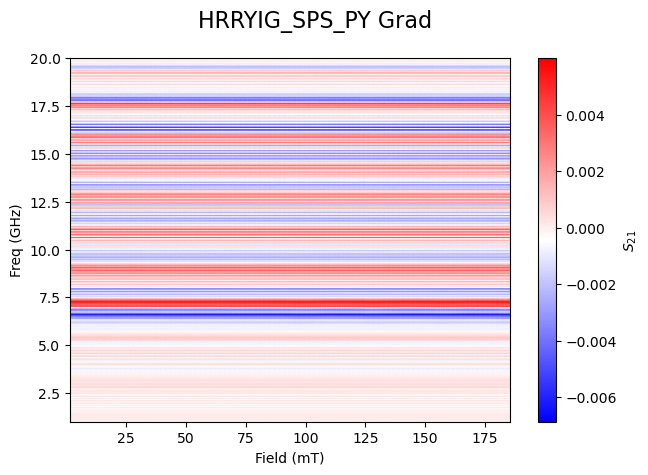

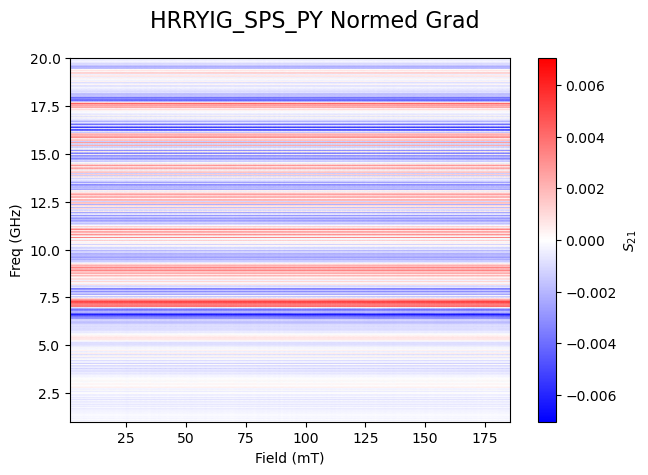

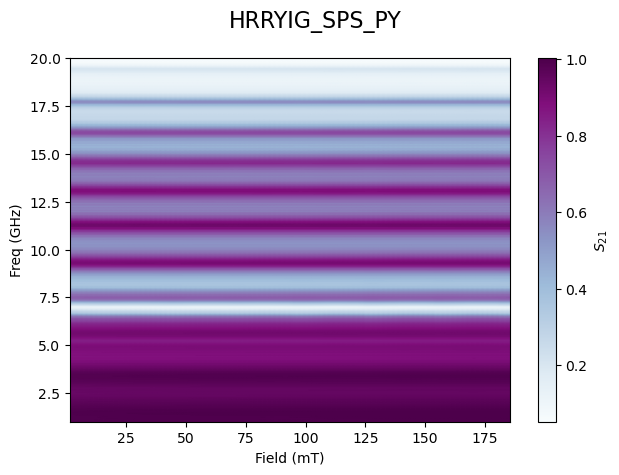

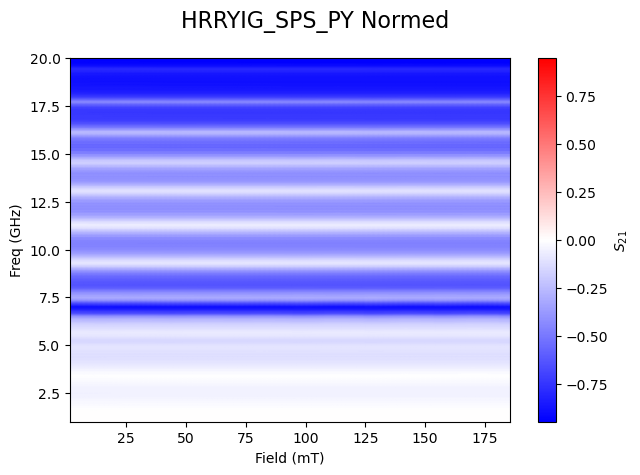

Processing directory: d:\Working files\cavityCoupling\experimental data\HRRPY180\HRRPY180


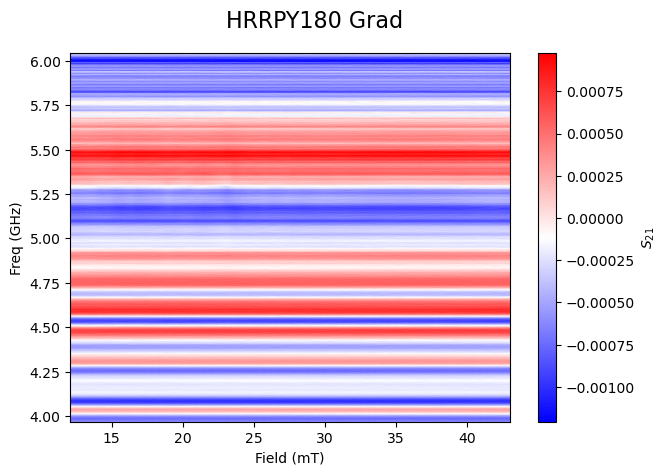

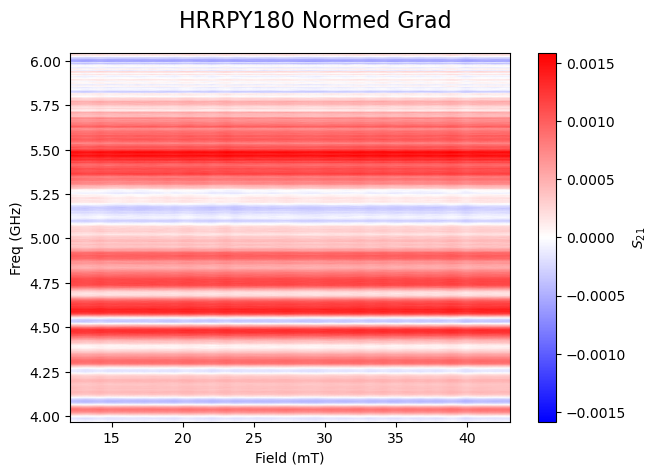

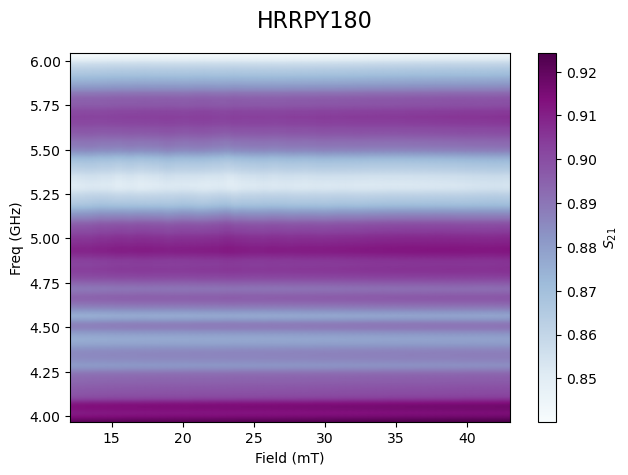

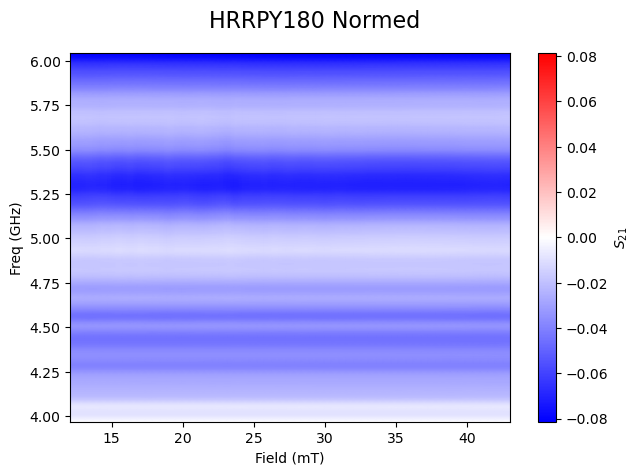

Processing directory: d:\Working files\cavityCoupling\experimental data\HRRPY180\HRRYIG_BJ_PY


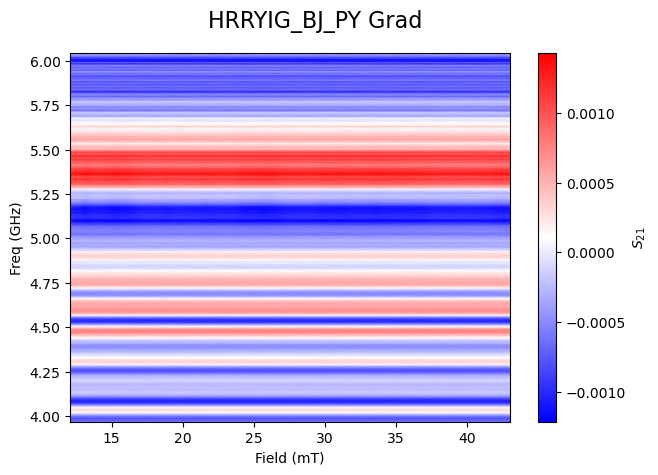

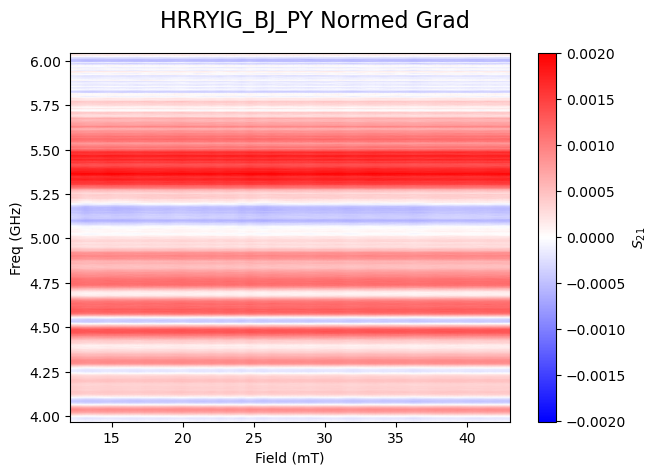

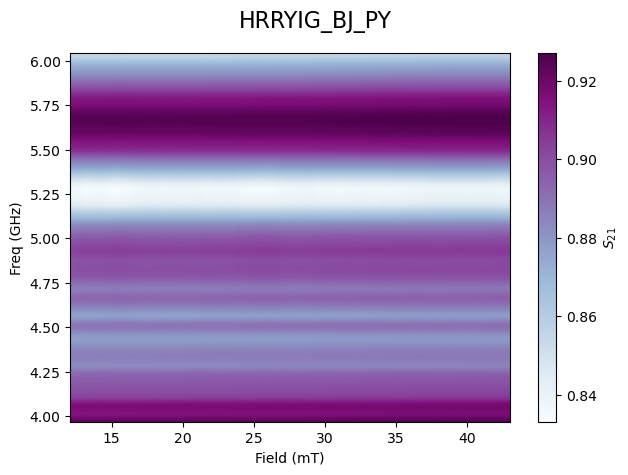

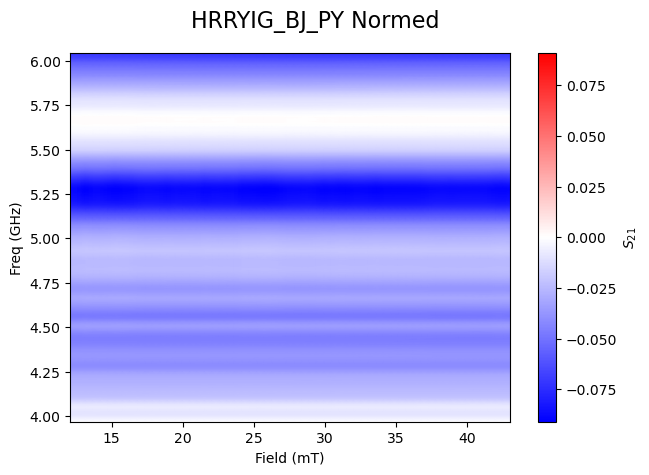

Processing directory: d:\Working files\cavityCoupling\experimental data\HRRYIG\HRRYIG180


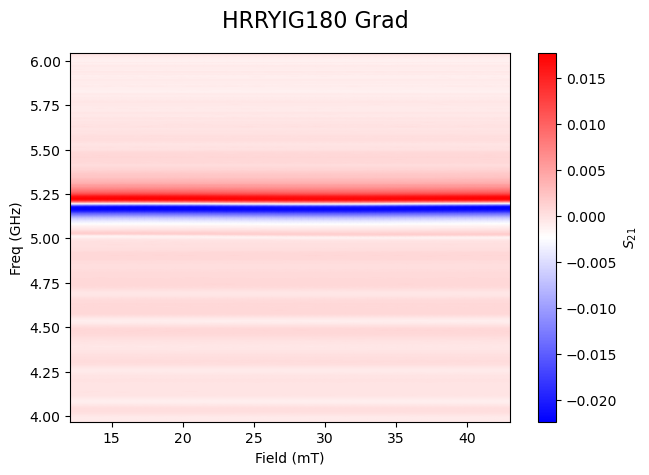

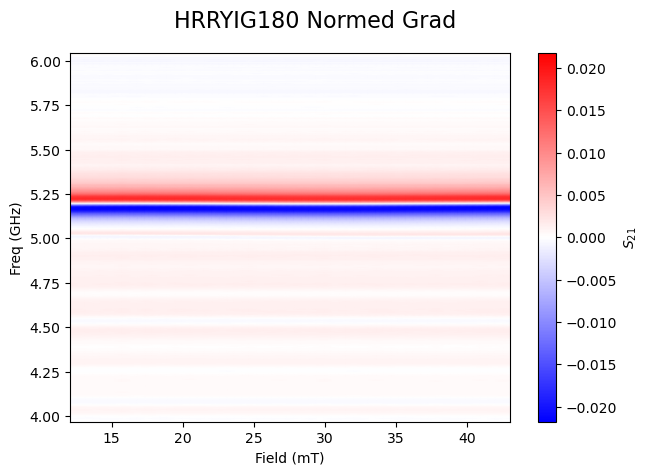

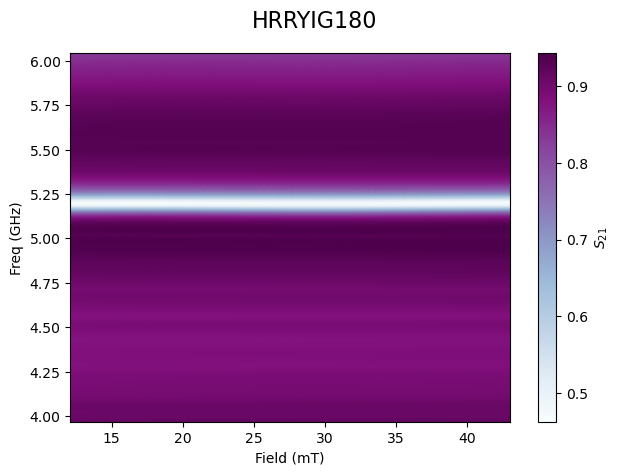

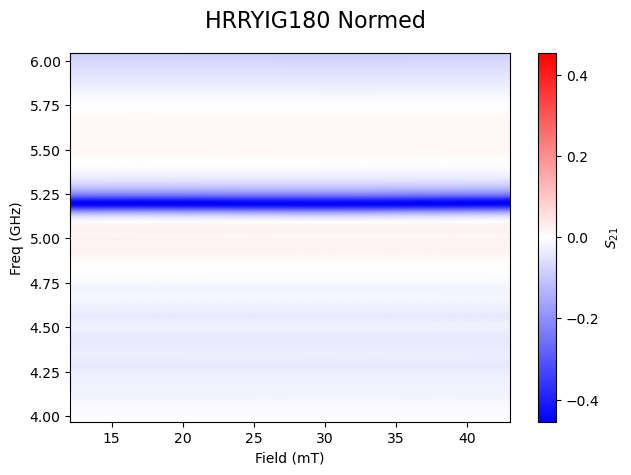

Processing directory: d:\Working files\cavityCoupling\experimental data\HRRYIG_PY\HRRYIG_PY


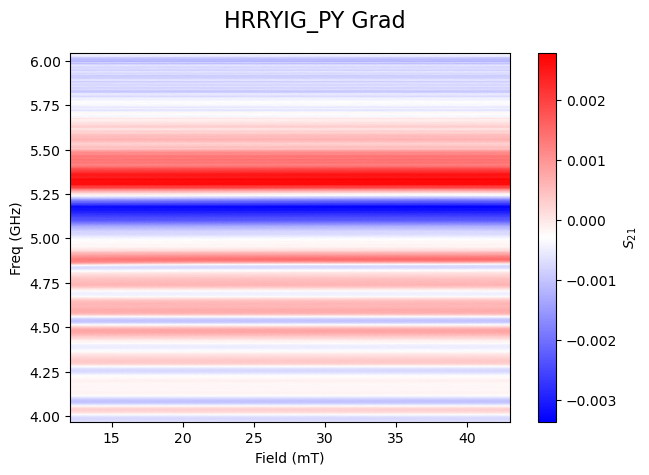

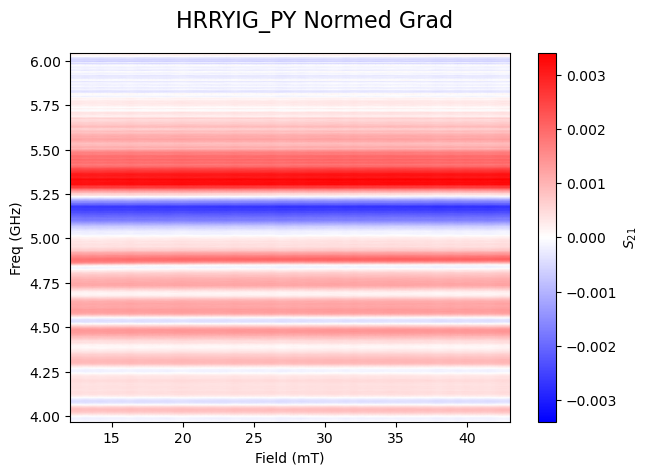

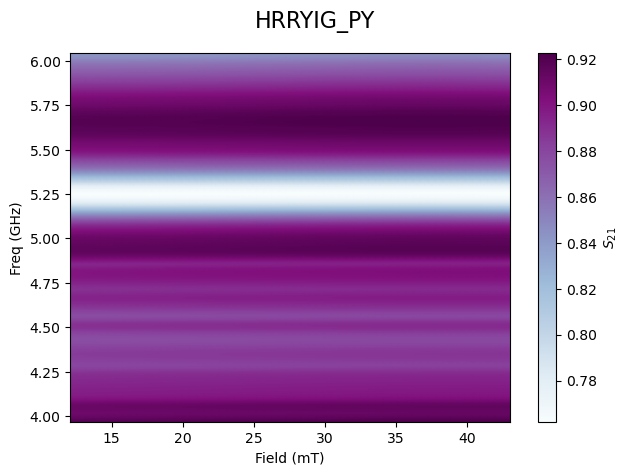

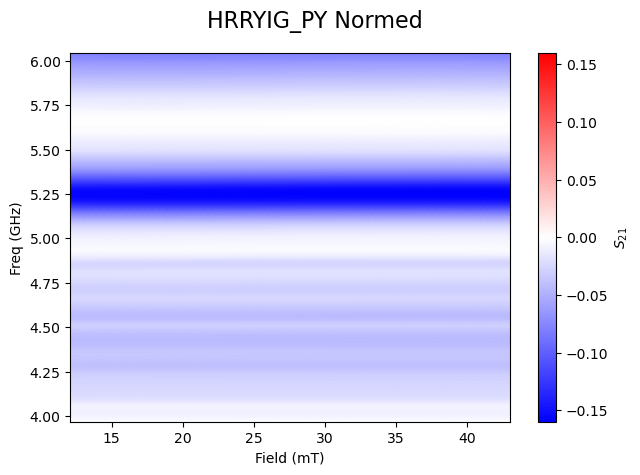

Processing directory: d:\Working files\cavityCoupling\experimental data\HRRYIG_PY\HRRYIG_SPS_PY


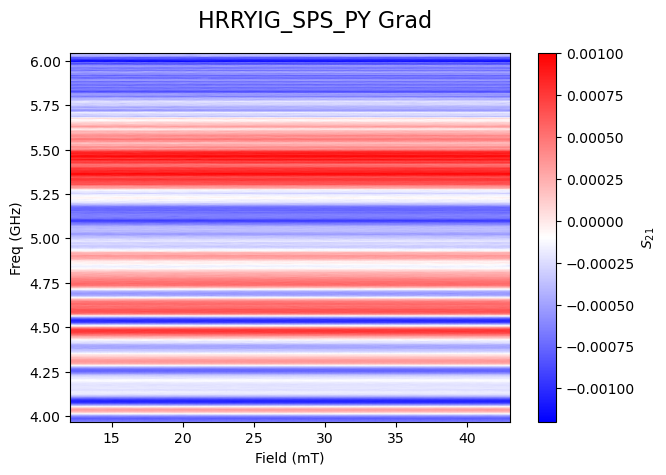

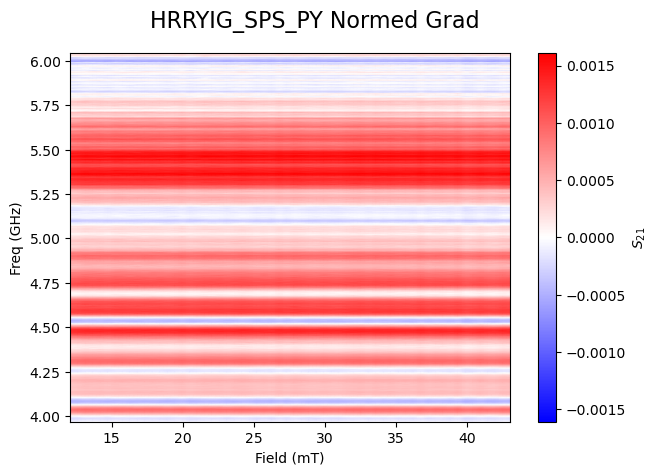

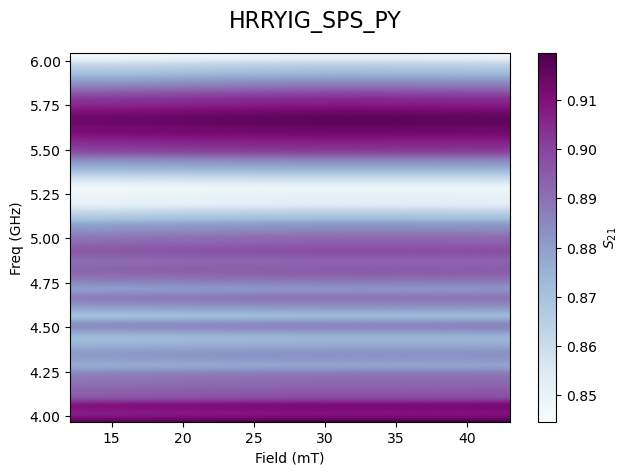

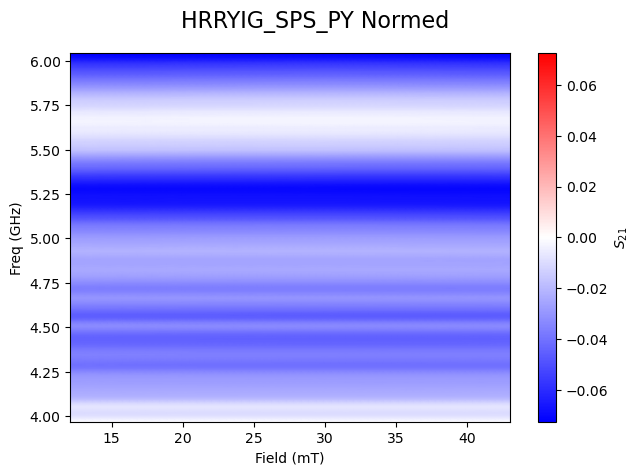

In [5]:
cwd = os.getcwd()
dirs = os.listdir(cwd)

zoom_indices = None
for d in dirs:
    if os.path.isdir(d) and d.startswith("HRR"):
        # Check if there are any directories inside d
        subdirs = [name for name in os.listdir(d) if os.path.isdir(os.path.join(d, name))]
        for sd in subdirs:
            tar_dir = os.path.join(cwd, d, sd)
            print(f"Processing directory: {tar_dir}")
            s_params = read_s_params(tar_dir)
            s_param_plot(s_parameters=s_params,sub_dir=tar_dir,norm=False,sigma=5,cmap="bwr",smooth=None, zoom_indices=zoom_indices) 
            s_param_plot(s_parameters=s_params,sub_dir=tar_dir,sigma=10,cmap="bwr", smooth=None, zoom_indices=zoom_indices) 
            s_param_plot(s_parameters=s_params,sub_dir=tar_dir,norm=False,grad=False,smooth=None,cmap="BuPu", zoom_indices=zoom_indices) 
            s_param_plot(s_parameters=s_params,sub_dir=tar_dir,grad=False,smooth=None,cmap="bwr", zoom_indices=zoom_indices) 

zoom_indices = [slice(20,80),slice(1000,1700)]
for d in dirs:
    if os.path.isdir(d) and d.startswith("HRR"):
        # Check if there are any directories inside d
        subdirs = [name for name in os.listdir(d) if os.path.isdir(os.path.join(d, name))]
        for sd in subdirs:
            tar_dir = os.path.join(cwd, d, sd)
            print(f"Processing directory: {tar_dir}")
            s_params = read_s_params(tar_dir)
            s_param_plot(s_parameters=s_params,sub_dir=tar_dir,norm=False,sigma=5,cmap="bwr",smooth=None, zoom_indices=zoom_indices) 
            s_param_plot(s_parameters=s_params,sub_dir=tar_dir,sigma=10,cmap="bwr", smooth=None, zoom_indices=zoom_indices) 
            s_param_plot(s_parameters=s_params,sub_dir=tar_dir,norm=False,grad=False,smooth=None,cmap="BuPu", zoom_indices=zoom_indices) 
            s_param_plot(s_parameters=s_params,sub_dir=tar_dir,grad=False,smooth=None,cmap="bwr", zoom_indices=zoom_indices) 

In [6]:
# data = read_s_params(directory)
# data['S21_Real']+1j*data['S21_Imaginary']
# np.savez("s_params_BJ.npz", **data, allow_pickle=False)

In [7]:
# s21 = data['S21_Real'] + 1j * data['S21_Imaginary']

# pd.DataFrame(s21, index=field).to_csv("s21.csv")

In [8]:
# s21=read_s_params(directory)

In [9]:
# reqd_field = 70  # mT

# index_50 = np.argmin(np.abs(field - reqd_field))

# files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# s21 = pd.read_csv(os.path.join(directory,files[index_50]), header=0, index_col=0)

# s21

In [10]:
from scipy.ndimage import gaussian_filter1d

def line_plots_mag(directory, num_lines=5,sigma=2, py_fields_only=True, norm_index=1, field_lims=[10,40]):
    
    dir_struct = [i for i in os.listdir(directory) if i.endswith('.csv')]

    if py_fields_only:
        idcs = np.where((field >= field_lims[0]) & (field <= field_lims[1]))[0]

        idcs = np.linspace(idcs[0], idcs[-1], num_lines, dtype=int)
    else:
        idcs = np.linspace(10, len(dir_struct)-1, num_lines, dtype=int)
    
    s21_ = pd.read_csv(os.path.join(directory, dir_struct[norm_index]), header=0, index_col=0)
    data0field = 20*np.log(np.abs(s21_['S21_Real'] + 1j * s21_['S21_Imaginary']))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("S21 (dB)")

    shift_up = 0
    lower_bound = 0
    for idx in idcs:
        s21 = pd.read_csv(os.path.join(directory, dir_struct[idx]), header=0, index_col=0)
        data_field = 20*np.log(np.abs(s21['S21_Real'] + 1j * s21['S21_Imaginary']))
        data = data_field - data0field
        smoothed_data = data  # No smoothing applied here, but you can uncomment the next line to apply Gaussian smoothing
        # smoothed_data = gaussian_filter1d(data, sigma=sigma)
        maximum = np.max(np.abs(smoothed_data))
        lower_bound = np.abs(np.min(smoothed_data))
        ax.plot(s21.index/1e9, smoothed_data+shift_up+lower_bound, label=f"{field[idx]:.0f} mT")
        shift_up += maximum*2
    
    plt.legend(loc="upper left")
    # ax.set_xlim(6,8)
    fig.suptitle(os.path.basename(directory)+" mag")
    plt.xlim(1,10)
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(os.path.dirname(directory)), 'line plots', os.path.basename(directory)+"_line_plots_mag.png"), transparent=True)
    plt.show()

def line_plots_der(directory, num_lines=5, sigma=3, py_fields_only=True, norm_index=1, field_lims=[10,40]):
    
    dir_struct = [i for i in os.listdir(directory) if i.endswith('.csv')]
    
    if py_fields_only:
        idcs = np.where((field >= field_lims[0]) & (field <= field_lims[1]))[0]

        idcs = np.linspace(idcs[0], idcs[-1], num_lines, dtype=int)
    else:
        idcs = np.linspace(10, len(dir_struct)-1, num_lines, dtype=int)
    
    s21_ = pd.read_csv(os.path.join(directory, dir_struct[norm_index]), header=0, index_col=0)
    data0field = 20*np.log(np.abs(s21_['S21_Real'] + 1j * s21_['S21_Imaginary']))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("S21 (dB)")

    shift_up = 0
    lower_bound = 0
    for idx in idcs:
        s21 = pd.read_csv(os.path.join(directory, dir_struct[idx]), header=0, index_col=0)
        data_field = 20*np.log(np.abs(s21['S21_Real'] + 1j * s21['S21_Imaginary']))
        data = data_field - data0field
        derivative = np.gradient(data, s21.index)
        smoothed_derivative = derivative
        # smoothed_derivative = gaussian_filter1d(derivative, sigma=sigma)
        maximum = np.max(np.abs(smoothed_derivative))
        lower_bound = np.abs(np.min(smoothed_derivative))
        ax.plot(s21.index/1e9, smoothed_derivative+shift_up+lower_bound, label=f"{field[idx]:.0f} mT")
        shift_up += maximum*2
    
    plt.legend(loc="upper left")
    # ax.set_xlim(6,8)
    fig.suptitle(os.path.basename(directory)+" grad")
    plt.xlim(1,10)
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(os.path.dirname(directory)), 'line plots', os.path.basename(directory)+"_line_plots_grad.png"), transparent=True)
    plt.show()

In [11]:

# plt.plot(s21.index/1e9, 20*np.log(np.abs(s21['S21_Real'] + 1j * s21['S21_Imaginary'])))
# s21_ = pd.read_csv(os.path.join(directory, "0300.csv"), header=0, index_col=0)
# data0field = 20*np.log(np.abs(s21['S21_Real'] + 1j * s21['S21_Imaginary']))
# data_field = 20*np.log(np.abs(s21_['S21_Real'] + 1j * s21_['S21_Imaginary']))
# data = data_field - data0field
# derivative = np.gradient(data, s21.index)
# smoothed_derivative = gaussian_filter1d(derivative, sigma=3)
# smoothed_data = gaussian_filter1d(data, sigma=25)

# plt.plot(s21.index/1e9, data0field, label="$S_{21}$(0 Oe)")
# plt.legend()
# plt.ylabel("Magnitude (dB)")
# plt.xlabel("Frequency (GHz)")
# plt.show()

# plt.plot(s21.index/1e9, data_field, label="$S_{21}$(300 Oe)")
# plt.legend()
# plt.ylabel("Magnitude (dB)")
# plt.xlabel("Frequency (GHz)")
# plt.show()

# plt.plot(s21.index/1e9, data, label="$S_{21}$(300 Oe) - $S_{21}$(0 Oe)")
# plt.legend()
# plt.ylabel("Magnitude (dB)")
# plt.xlabel("Frequency (GHz)")
# plt.show()

# plt.plot(s21.index/1e9, smoothed_derivative, label="Derivative")
# plt.legend()
# plt.ylabel("Magnitude (dB)")
# plt.xlabel("Frequency (GHz)")
# plt.show()

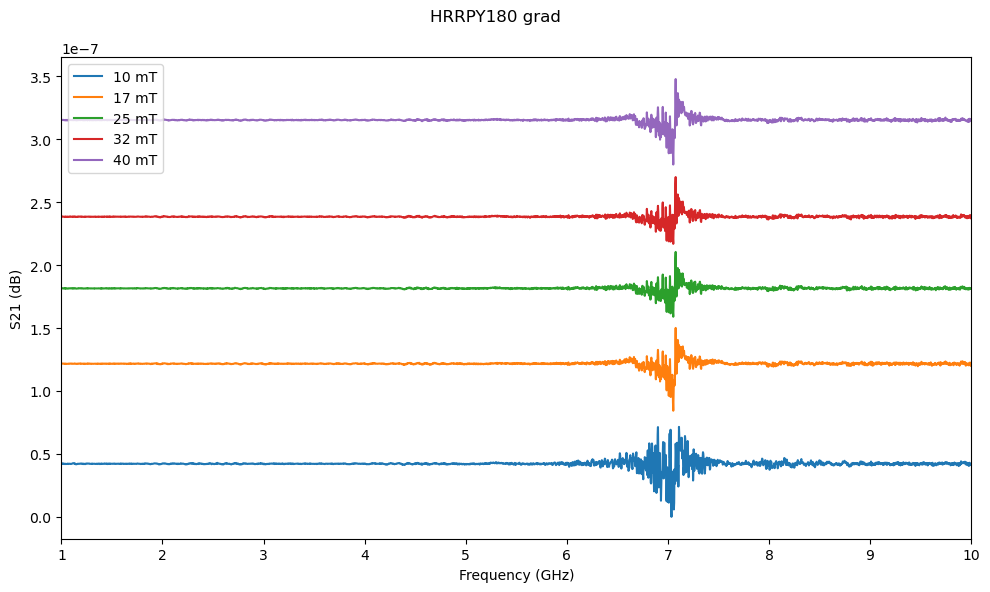

In [12]:
line_plots_der(directory)

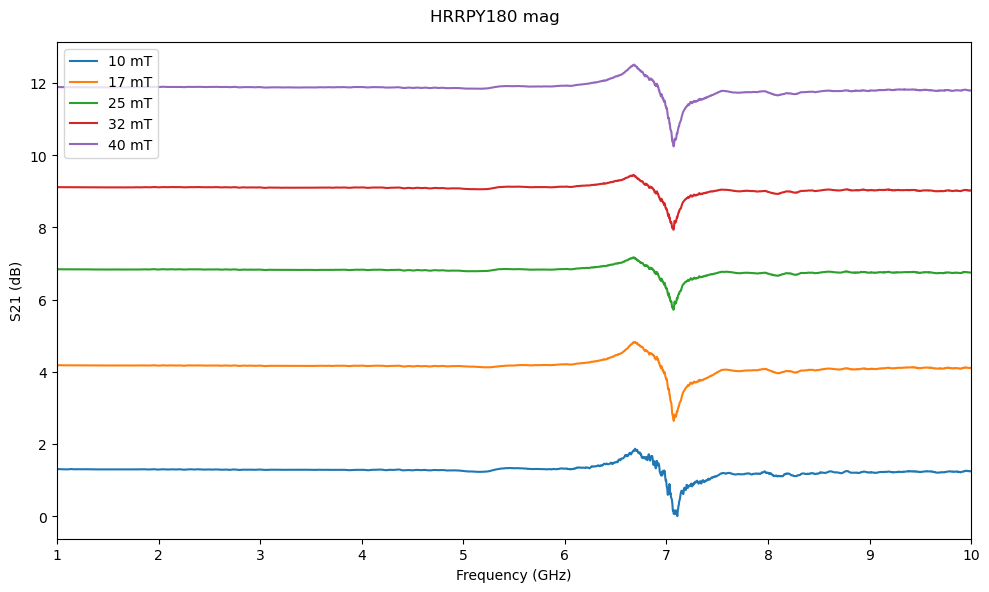

In [13]:
line_plots_mag(directory)

Processing directory: d:\Working files\cavityCoupling\experimental data\HRRPY180\HRRPY180


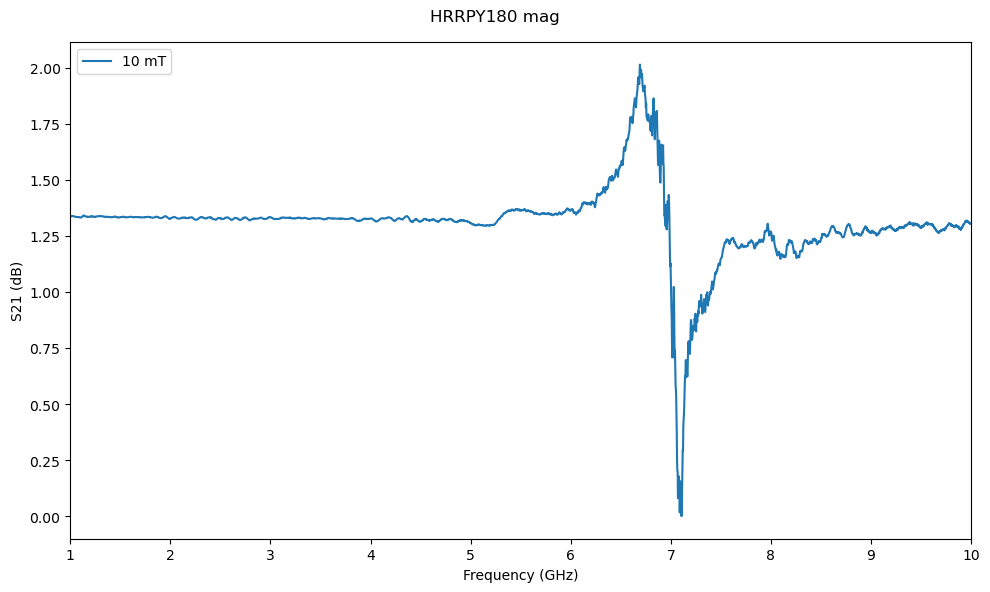

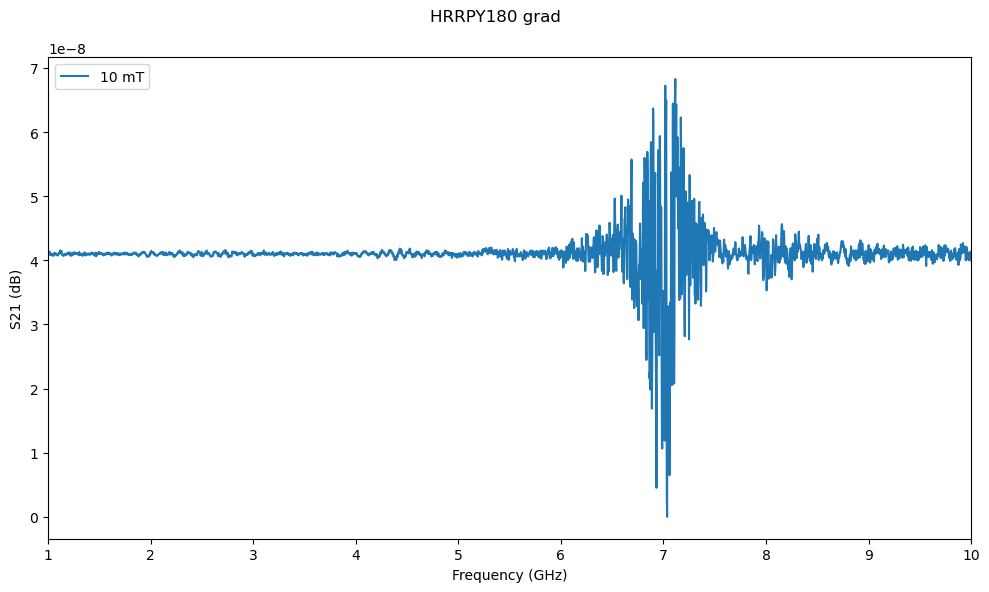

In [14]:
index = 0
field_lims = [10,150]
num_lines = 1

cwd = os.getcwd()
dirs = os.listdir(cwd)
for d in dirs:
    if os.path.isdir(d) and d.startswith("HRR"):
        # Check if there are any directories inside d
        subdirs = [name for name in os.listdir(d) if os.path.isdir(os.path.join(d, name)) and name.startswith("HRRPY180")]
        for sd in subdirs:
            tar_dir = os.path.join(cwd, d, sd)
            print(f"Processing directory: {tar_dir}")
            line_plots_mag(tar_dir, norm_index=index, field_lims=field_lims, num_lines=num_lines)
            line_plots_der(tar_dir, norm_index=index, field_lims=field_lims, num_lines=num_lines)